## 1. Introducción
Este notebook implementa un sistema de detección de manchas solares utilizando el modelo de detección de objetos YOLOv8.
El objetivo es identificar y localizar manchas solares en imágenes solares.
Utilizaremos un modelo YOLOv8 pre-entrenado y lo ajustaremos (fine-tuning) con un dataset de imágenes de manchas solares.
**Nota:** Este notebook utiliza un dataset externo para el entrenamiento debido a problemas con la generación automática de anotaciones a partir de los datos SRS.


### Importar Biblioteca

In [21]:
import os
import glob
import time
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ultralytics import YOLO
from IPython.display import Image, display
#from PIL import Image
import yaml

%matplotlib inline


### Definición de Rutas y Configuraciones

In [16]:
dataset_config = "./datasets/data.yaml"  # Ruta al archivo data.yaml
project_name = "sunspot_model"  # Nombre del proyecto
run_name = "test_run"  # Nombre de la ejecución del entrenamiento
model_dir = os.path.join(
    project_name, run_name, "weights"
)  # Directorio para guardar el modelo entrenado

## Cargar Modelo Pre-entrenado

In [4]:
# Comprobar si existe un modelo anterior para reanudar
best_model_path = os.path.join(model_dir, "best.pt")
last_model_path = os.path.join(model_dir, "last.pt")

# Cargar el modelo (previo o nuevo)
if os.path.exists(best_model_path):
    print(f"Reanudando entrenamiento desde el mejor modelo guardado: {best_model_path}")
    model = YOLO(best_model_path)
elif os.path.exists(last_model_path):
    print(
        f"Reanudando entrenamiento desde el último modelo guardado: {last_model_path}"
    )
    model = YOLO(last_model_path)
else:
    print("No se encontró modelo previo. Iniciando nuevo entrenamiento con YOLOv8n")
    model = YOLO("yolov8n.pt")

No se encontró modelo previo. Iniciando nuevo entrenamiento con YOLOv8n


## Entrenar el Modelo

In [ ]:
# Registrar tiempo de inicio
start_time = time.time()

# Entrenar o reanudar entrenamiento
results = model.train(
    data="./datasets/data.yaml",
    epochs=1,  # Número total de épocas deseadas
    imgsz=640,
    batch=16,
    patience=20,
    save=True,
    save_period=5,  # Guardar cada 5 épocas
    project=project_name,
    name="test_run",
    exist_ok=True,  # Permitir sobreescribir resultados anteriores
    # Si hay un modelo previo, reanudamos
    resume=os.path.exists(best_model_path) or os.path.exists(last_model_path),
    # Data augmentation parameters
    augment=True,  # Enable augmentation
    degrees=20,  # Rotate images by ±20 degrees
    scale=0.5,  # Random scale from 0.5 to 1.5
    fliplr=0.5,  # 50% probability of horizontal flip
    flipud=0.3,  # 30% probability of vertical flip
    hsv_h=0.015,  # Slight hue adjustment
    hsv_s=0.7,  # Saturation adjustment
    hsv_v=0.4,  # Value (brightness) adjustment
    mosaic=0.0,  # Disable mosaic #preguntar por qué
)

# Calcular tiempo total
elapsed_time = time.time() - start_time
print(
    f"Tiempo total de entrenamiento: {elapsed_time:.2f} segundos ({elapsed_time/60:.2f} minutos)"
)

### Métricas de Evaluación

Métricas de Evaluación (Última Época):
Tiempo de entrenamiento: 2234.57 segundos
Tiempo de entrenamiento: 37.24 minutos
Precisión: 0.4664
Recall: 0.5696
mAP50: 0.5346
mAP50-95: 0.2378

Matriz de Confusión:


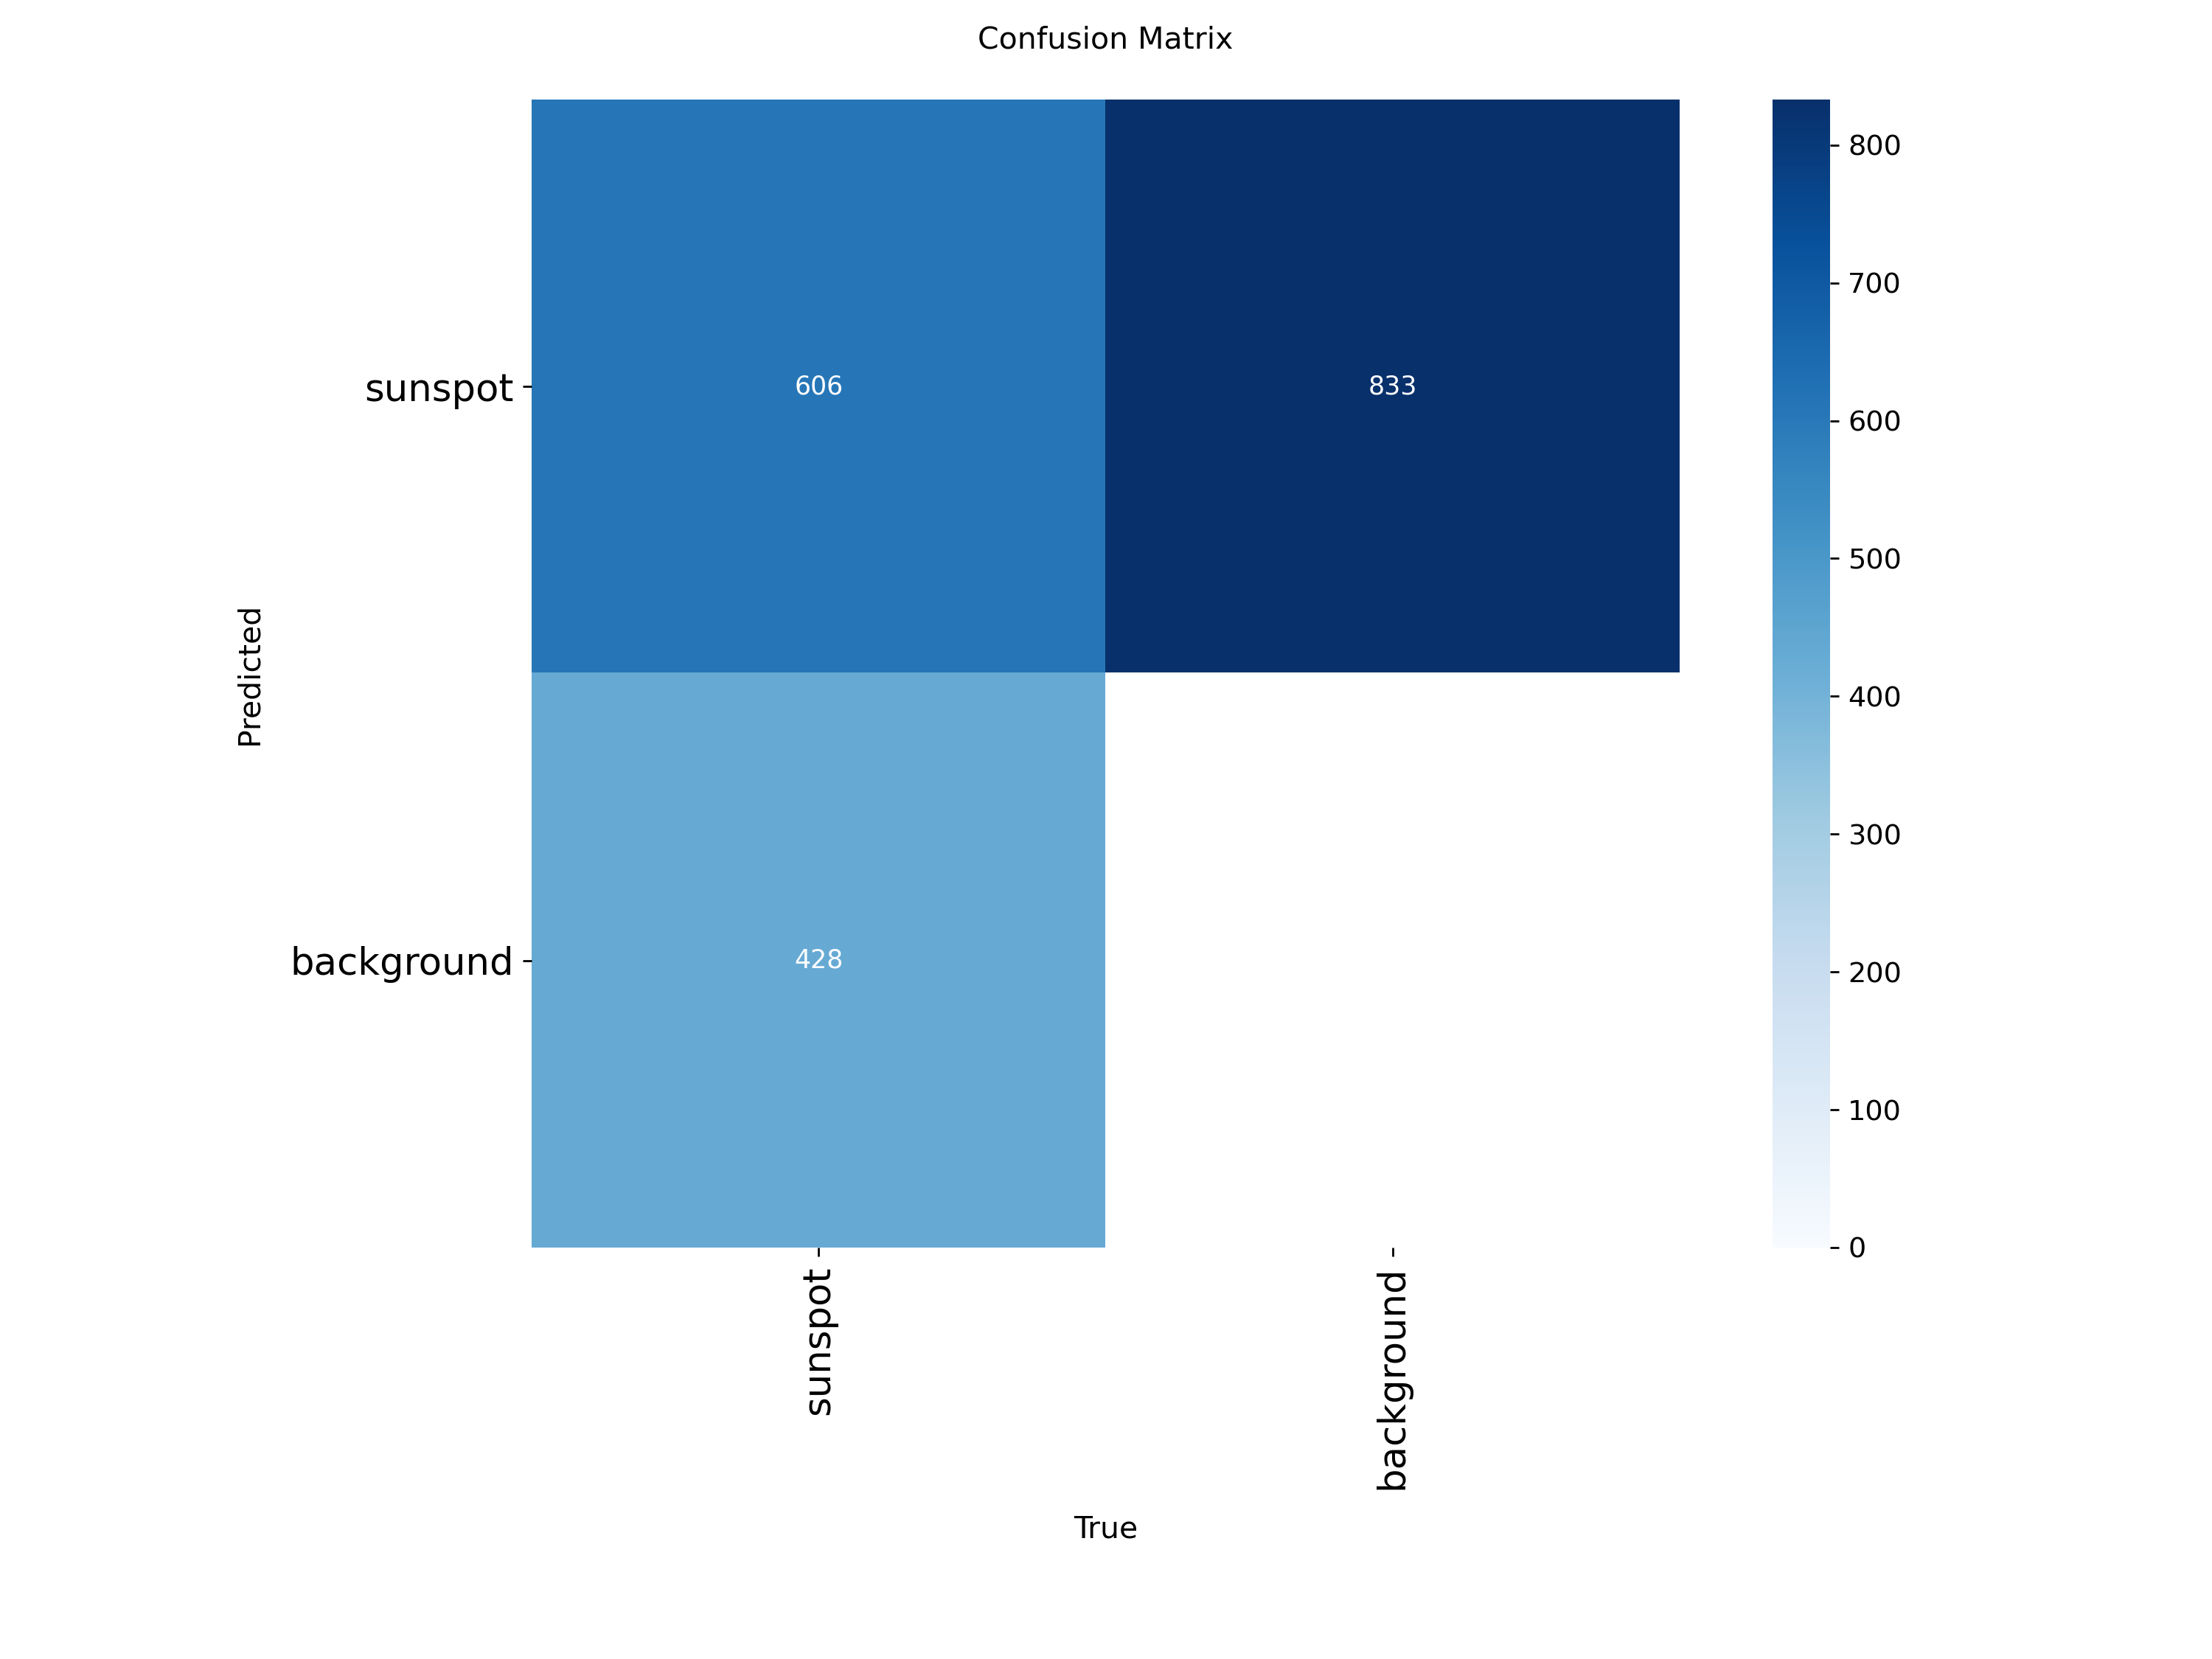


Curva Precisión-Recall:


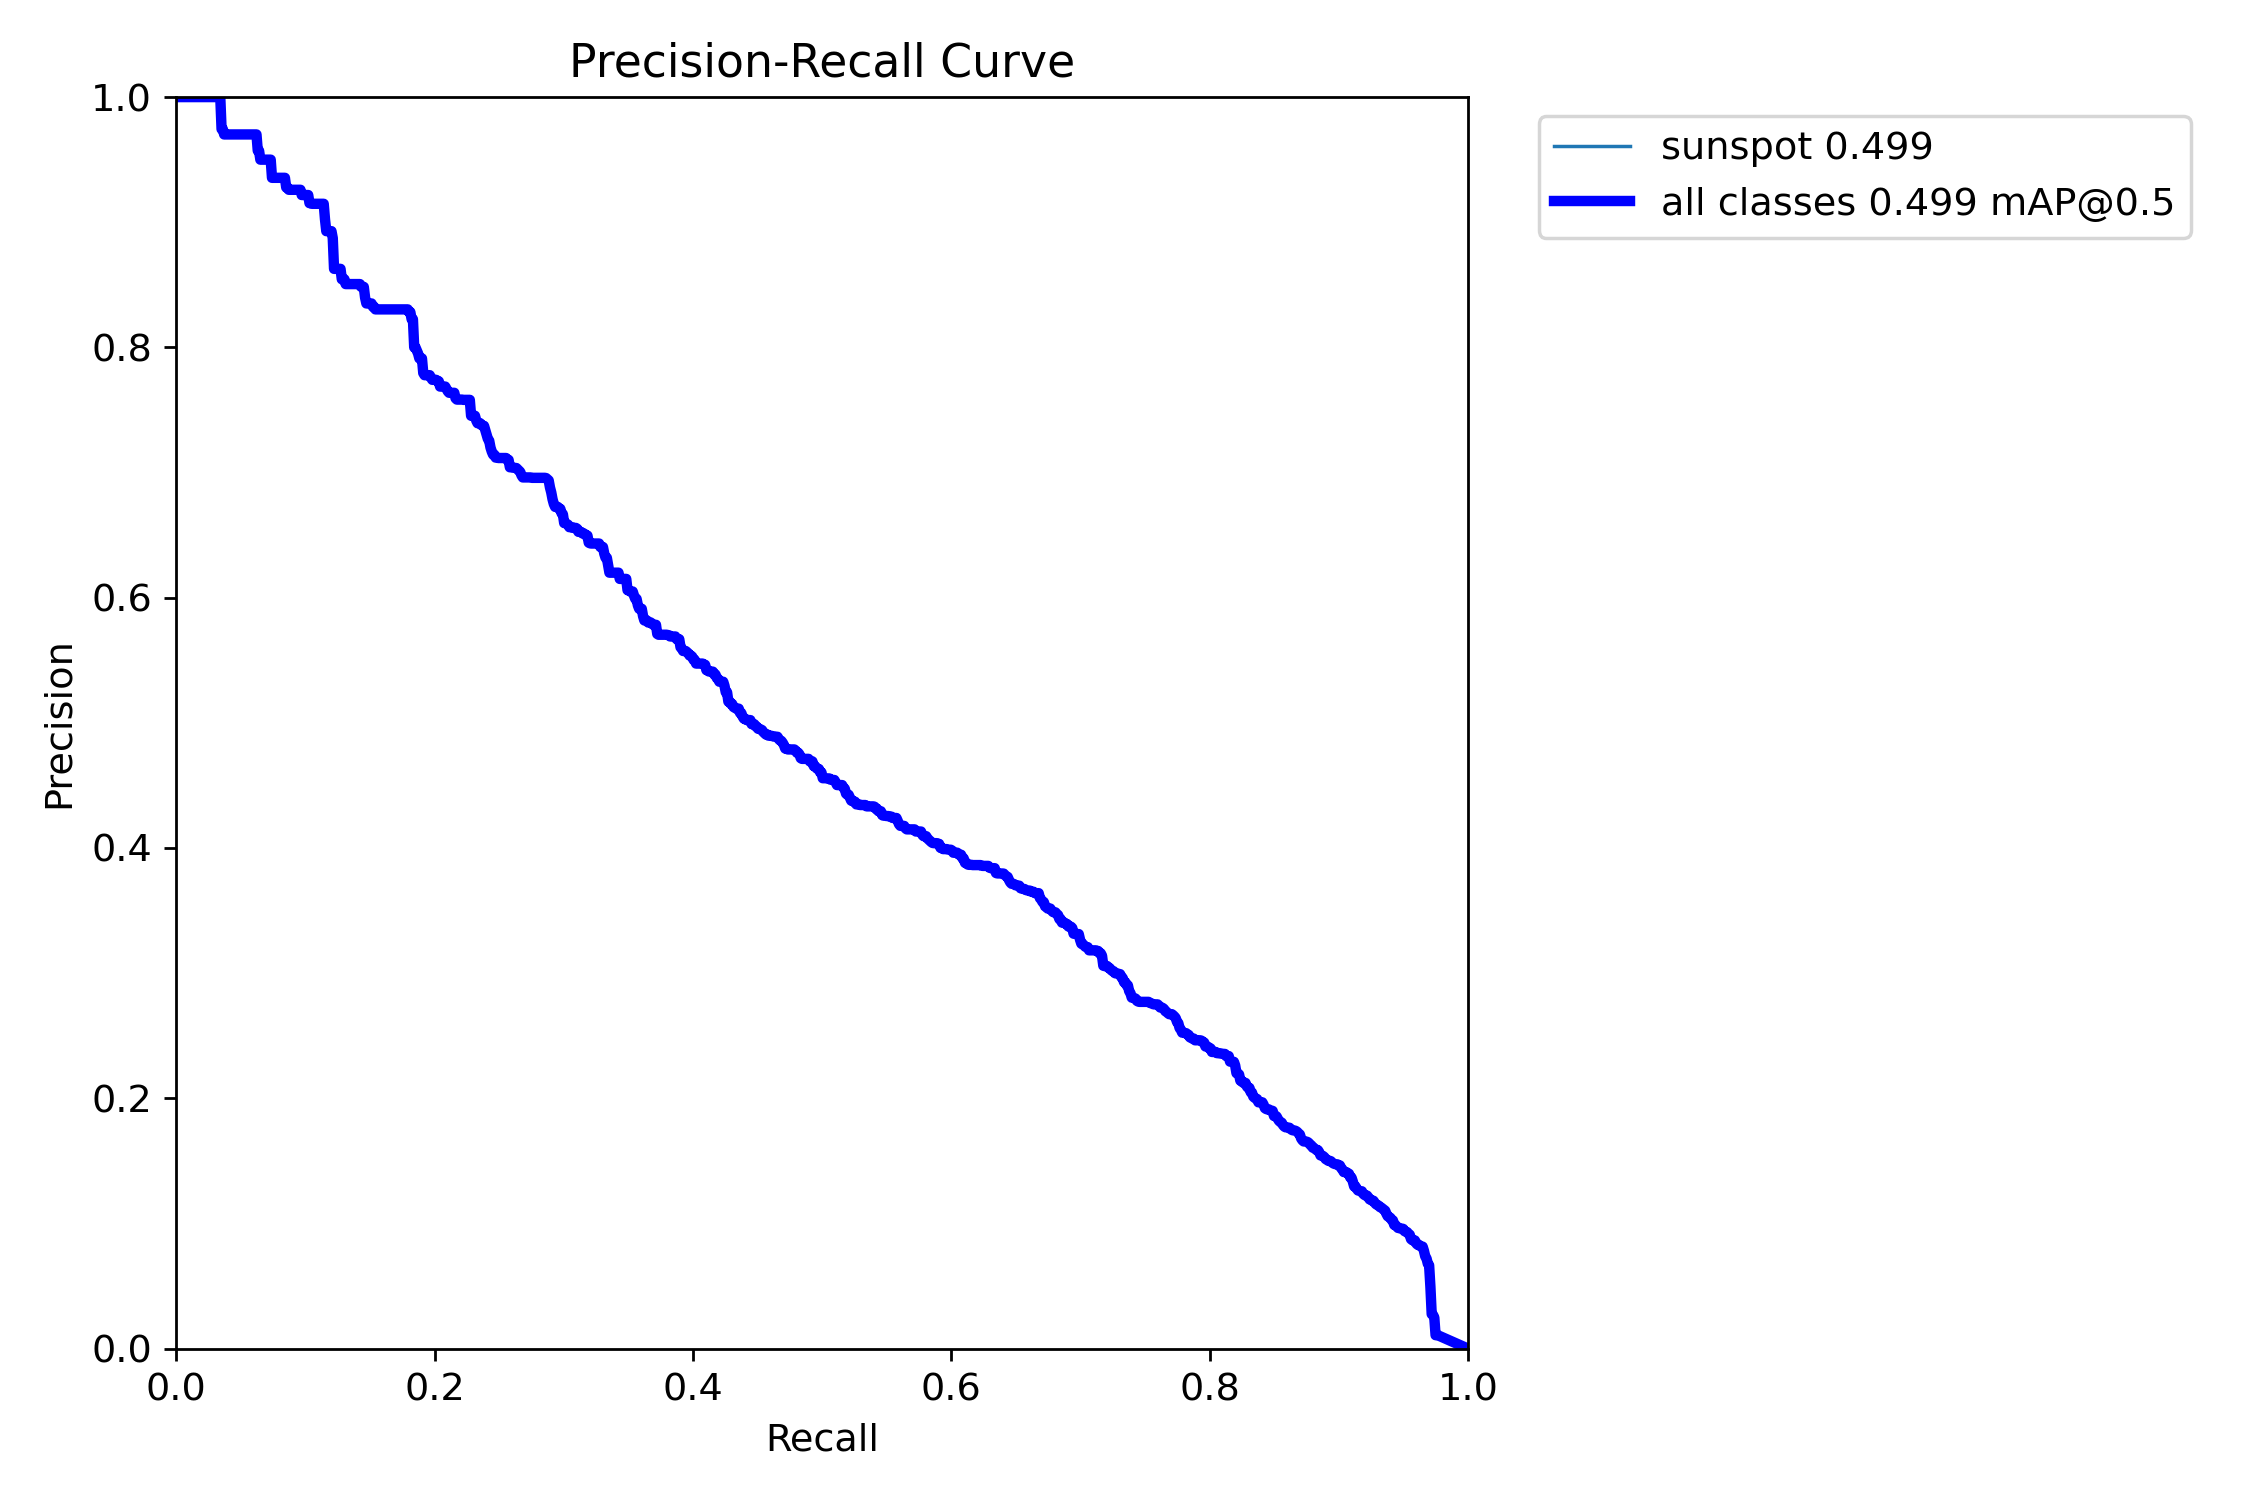

In [24]:
# Cargar las métricas de evaluación desde el archivo `results.csv`.
results_csv_path = os.path.join(project_name, run_name, "results.csv")

try:
    results_df = pd.read_csv(results_csv_path)
    last_epoch_metrics = results_df.iloc[-1]

    print("Métricas de Evaluación (Última Época):")
    print(f"Tiempo de entrenamiento: {last_epoch_metrics['time']:.2f} segundos")
    print(f"Tiempo de entrenamiento: {last_epoch_metrics['time']/60:.2f} minutos")
    print(f"Precisión: {last_epoch_metrics['metrics/precision(B)']:.4f}")
    print(f"Recall: {last_epoch_metrics['metrics/recall(B)']:.4f}")
    print(f"mAP50: {last_epoch_metrics['metrics/mAP50(B)']:.4f}")
    print(f"mAP50-95: {last_epoch_metrics['metrics/mAP50-95(B)']:.4f}")

except FileNotFoundError:
    print(f"Error: No se pudo encontrar el archivo {results_csv_path}")

# ### 5.2. Mostrar Visualizaciones de Evaluación
# Mostrar las visualizaciones de evaluación generadas, como la matriz de confusión y la curva de precisión-recall.
confusion_matrix_path = os.path.join(project_name, run_name, "confusion_matrix.png")
pr_curve_path = os.path.join(project_name, run_name, "PR_curve.png")

print("\nMatriz de Confusión:")
try:
    display(Image(filename=confusion_matrix_path))
except FileNotFoundError:
    print(f"Error: No se pudo encontrar la imagen {confusion_matrix_path}")

print("\nCurva Precisión-Recall:")
try:
    display(Image(filename=pr_curve_path))
except FileNotFoundError:
    print(f"Error: No se pudo encontrar la imagen {pr_curve_path}")

## Visualizar Predicciones en Imágenes de Prueba

In [37]:
# Obtener una lista de imágenes de prueba
test_images = glob.glob("./datasets/test/images/*.jpg")
# Seleccionar una imagen aleatoria
random_img_path = random.choice(test_images)
print(f"Imagen seleccionada: {random_img_path}")

Imagen seleccionada: ./datasets/test/images\sunspots_1024_20120512_jpg.rf.35d373ab1e8fcd9f3ae22cae474513cd.jpg


In [ ]:
# Cargar la imagen
img = cv2.imread(random_img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Obtener la ruta al archivo de etiquetas correspondiente
label_path = random_img_path.replace("images", "labels").replace(".jpg", ".txt")

# Cargar etiquetas (ground truth)
labels = []

with open(label_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center = float(parts[1])
        y_center = float(parts[2])
        width = float(parts[3])
        height = float(parts[4])
        # Convertir coordenadas normalizadas a píxeles
        img_height, img_width = img.shape[:2]
        x1 = int((x_center - width / 2) * img_width)
        y1 = int((y_center - height / 2) * img_height)
        x2 = int((x_center + width / 2) * img_width)
        y2 = int((y_center + height / 2) * img_height)
        labels.append((class_id, x1, y1, x2, y2))

labels

[(0, 551, 373, 717, 459),
 (0, 292, 646, 381, 691),
 (0, 105, 365, 186, 413),
 (0, 87, 556, 118, 600)]


image 1/1 c:\Users\DarkNacho\Documents\Doctorado\2025\Machine Learning\Machine-Learning\SunSpot\datasets\test\images\sunspots_1024_20120512_jpg.rf.35d373ab1e8fcd9f3ae22cae474513cd.jpg: 640x640 8 sunspots, 404.0ms
Speed: 7.7ms preprocess, 404.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


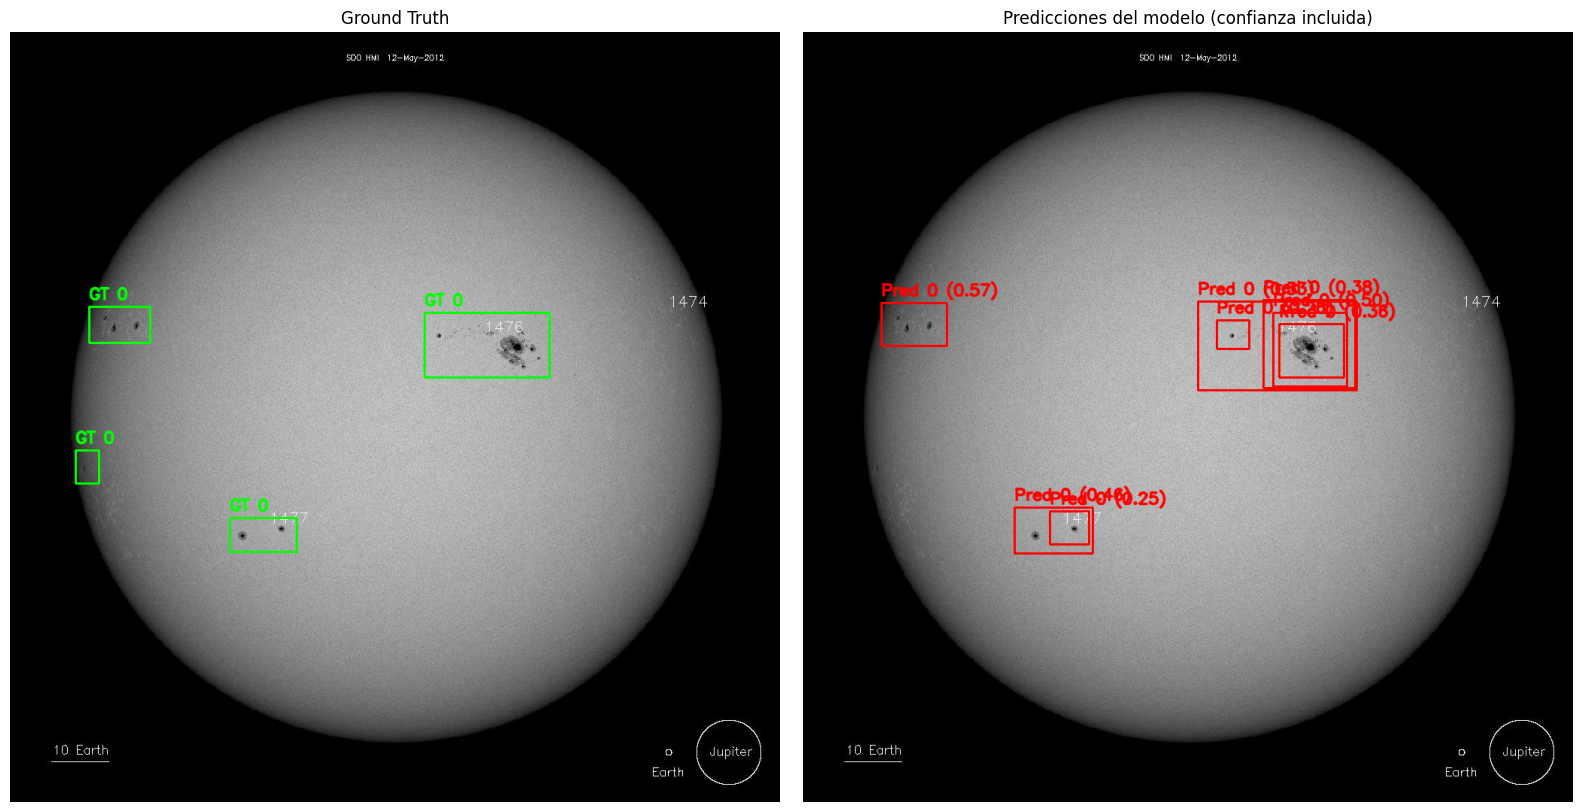

In [41]:
# Crear una copia para dibujar las etiquetas ground truth
img_gt = img.copy()
for label in labels:
    class_id, x1, y1, x2, y2 = label
    cv2.rectangle(img_gt, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Asegura que el texto esté dentro de la imagen
    text_y = max(y1 - 10, 10)
    cv2.putText(
        img_gt,
        f"GT {class_id}",
        (x1, text_y),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (0, 255, 0),
        2,
        cv2.LINE_AA,
    )

# Realizar predicción con el modelo entrenado (sin filtrar por confianza)
pred_results = model.predict(random_img_path)

# Dibujar las predicciones con su confianza
img_pred = img.copy()
for box in pred_results[0].boxes:
    x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
    conf = float(box.conf[0])
    class_id = int(box.cls[0])
    cv2.rectangle(img_pred, (x1, y1), (x2, y2), (255, 0, 0), 2)
    # Asegura que el texto esté dentro de la imagen
    text_y = max(y1 - 10, 10)
    cv2.putText(
        img_pred,
        f"Pred {class_id} ({conf:.2f})",
        (x1, text_y),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.7,
        (255, 0, 0),
        2,
        cv2.LINE_AA,
    )

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title("Ground Truth")
plt.imshow(img_gt)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Predicciones del modelo (confianza incluida)")
plt.imshow(img_pred)
plt.axis("off")

plt.tight_layout()
plt.show()

## 7. Conclusiones
Este notebook presenta una implementación inicial de la detección de manchas solares utilizando YOLOv8.
Se realizó un entrenamiento de prueba con un dataset externo para evaluar la viabilidad del modelo y la configuración del entorno.
Los resultados obtenidos (Precisión: 0.4664, Recall: 0.5696, mAP50: 0.5346, mAP50-95: 0.2378) son modestos,
lo cual es esperable dado que el entrenamiento se limitó a una sola época.
El objetivo principal de esta ejecución fue verificar la correcta carga de datos, el funcionamiento del entrenamiento
y la generación de métricas básicas. Los hiperparámetros utilizados fueron los valores por defecto del modelo, sin ajustes específicos.
Los siguientes pasos a seguir incluyen:
- Aumentar significativamente el número de épocas de entrenamiento para permitir que el modelo converja.
- Evaluar el modelo en un conjunto de validación independiente para obtener una estimación más precisa de su capacidad de generalización.
- Investigar la posibilidad de utilizar los datos SRS para generar anotaciones y abordar la clasificación McIntosh en una etapa posterior.